In [24]:
%matplotlib inline
import nltk.data;
from gensim.models import word2vec;
from sklearn.cluster import KMeans;
import pandas as pd;
import numpy as np;
import os;
import re;
import sys;
from nltk.corpus import stopwords
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');
from nltk.stem import PorterStemmer
from sklearn.neighbors import KDTree;
from nltk.tokenize import word_tokenize ,sent_tokenize
ps=PorterStemmer()

In [4]:
mydata =  pd.read_csv('trump.txt',sep=",")

In [5]:
print (mydata.head())

               source                                               text  \
0  Twitter for iPhone  Mexico is sending a big delegation to talk abo...   
1  Twitter for iPhone  Peggy Noonan the simplistic writer for Trump H...   
2  Twitter for iPhone  RT @realDonaldTrump: THE TRUTH! The Witch Hunt...   
3  Twitter for iPhone  RT @realDonaldTrump: GREAT NEWS! #MAGA https:/...   
4  Twitter for iPhone  I never called Meghan Markle “nasty.” Made up ...   

            created_at  retweet_count  favorite_count is_retweet  \
0  06-02-2019 18:19:47          23726           90265      False   
1  06-02-2019 18:13:04          14462           58856      False   
2  06-02-2019 13:00:57          15211               0       True   
3  06-02-2019 12:45:31          20071               0       True   
4  06-02-2019 12:44:24          23197           92749      False   

                id_str  
0  1135249668751929345  
1  1135247979617685504  
2  1135169433020915715  
3  1135165545408598016  
4  113516

In [6]:
total_rows = len(mydata);
print(total_rows)

22819


In [7]:
stop_words = set(stopwords.words('english'))
#print(stop_words)

In [9]:
def clean_text(all_tweets, filesave):
    
    out_file = open(filesave, 'w');
    
    for pos in range(len(all_tweets)):
    
        #Get the comment
        val = all_tweets.iloc[pos]['text'];
        
        #Normalize tabs and remove newlines
        no_tabs = str(val).replace('\t', ' ').replace('\n', '');
        
        #Remove all characters except A-Z and a dot.
        alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);
        
        #Normalize spaces to 1
        multi_spaces = re.sub(" +", " ", alphas_only);
        
        #Strip trailing and leading spaces
        no_spaces = multi_spaces.strip();
        
        #Normalize all charachters to lowercase
        clean_text = no_spaces.lower();
        
        #Get sentences from the tokenizer, remove the dot in each.
        sentences = tokenizer.tokenize(clean_text);
        sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];

        stop_words = set(stopwords.words('english')) 
        stop_words2 = ['poll''https','th','wh','dc','amp','pmo','tco','yth','iq','ol','ry','zh','de','ij','evo','eq','pu','un','fj','xcz','ing','rt']
        
        filtered_text =[]
        all_words=[]
             
        for i in sentences:
            for w in i:
                all_words.append(ps.stem(i))
        
        for sentence in sentences:
                filtered_text.append(' '.join(ps.stem(w) for w in nltk.word_tokenize(sentence) if w not in stop_words and w not in stop_words2 and len(w)>2))   
       
    #If the text has more than one space (removing single word comments) and one character, write it to the file.
      
        if len(filtered_text)>=2 and filtered_text.count(' ') >=0:
            for sentence in filtered_text:
                out_file.write("%s\n" % sentence)
                #print(sentence);
                    
    out_file.close();

In [10]:
clean_tweets = clean_text(mydata,"savetext.txt")

In [11]:

# Set values for various parameters
num_features =10;    # Dimensionality of the hidden layer representation
min_word_count = 50;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
                                                     
# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec
model = word2vec.Word2Vec(word2vec.LineSentence('savetext.txt'), workers=num_workers,
            size=num_features, min_count = min_word_count);
model.init_sims(replace=True);
# Save the model in trump_tweets
model_name = "trump_tweets";
model.save(model_name);

C:\Users\trimm\Anaconda1\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [29]:
def clustering_on_word2vecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='random');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx,kmeans_clustering;

In [30]:
# Keeping the most used words
Z = model.wv.syn0;
print(len(Z))

709


C:\Users\trimm\Anaconda1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


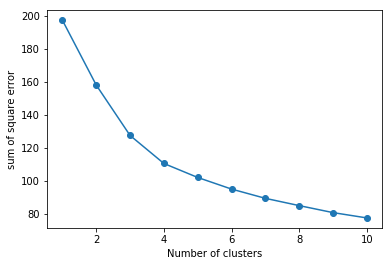

In [31]:
d = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random')
    km.fit(Z)
    d.append(km.inertia_)

# plot
plt.plot(range(1, 11), d, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('sum of square error')
plt.show()



In [32]:
centers, clusters,km = clustering_on_word2vecs(Z, 4);
centroid_map = dict(zip(model.wv.index2word, clusters));

In [33]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="white", max_words=200, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num) )

In [34]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

In [35]:
top_words = get_top_words(model.wv.index2word, 5000, centers, Z)

In [ ]:
cmaps = cycle(['flag', 'prism', 'ocean'])
for i in range(4):
    col = next(cmaps);
    display_cloud(i+1, col)

In [43]:
def get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]
    

In [38]:
keys = ['win', 'clinton', 'trump', 'obama', 'america',  'republican', ];
tables = [];
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key), key, show_sim=False))
    
pd.concat(tables, axis=1)

,win,clinton,trump,obama,america,republican
0,primari,crook,donald,investig,safe,senat
1,congratul,campaign,presid,obstruct,let,vote
2,saturday,fbi,run,spi,togeth,congress
3,tuesday,beat,via,angri,make,pass
4,mike,email,android,email,great,parti
5,live,investig,realdonaldtrump,rig,keep,enforc
6,gop,comey,debat,dem,maga,bill
7,hampshir,total,foxandfriend,elect,god,pelosi
8,victori,russian,web,system,bless,weak
9,ohio,collus,watch,campaign,http,commit


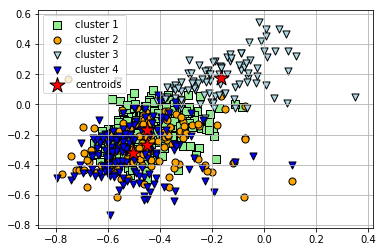

In [40]:
plt.scatter(
    Z[clusters == 0, 0], Z[clusters == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    Z[clusters == 1, 0], Z[clusters== 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    Z[clusters == 2, 0], Z[clusters== 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    Z[clusters == 3, 0], Z[clusters== 3, 1],
    s=50, c='blue',
    marker='v', edgecolor='black',
    label='cluster 4'
)

#plt.scatter(
 #   Z[clusters == 4, 0], Z[clusters== 4, 1],
  #  s=50, c='yellow',
   # marker='v', edgecolor='black',
   # label='cluster 5'
#)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()